## Predict how much energy will a building consume with Fedot.Industrial

Dataset published on Kaggle, aims to assess the value of energy efficiency improvements. For that purpose, four types of sources are identified: electricity, chilled water, steam and hot
water. The goal is to estimate the **energy consumption in kWh**. Dimensions correspond to the air temperature, dew temperature, wind direction and wind speed. These values were taken hourly during a week, and the output is the meter reading of the four aforementioned sources. In this way, was created four datasets:  **ChilledWaterPredictor**, **ElectricityPredictor**, **HotwaterPredictor**, and **SteamPredictor**.
Link to the dataset - https://www.kaggle.com/code/fatmanuranl/ashrae-energy-prediction2

In [1]:
import pandas as pd
from fedot_ind.api.utils.path_lib import PROJECT_PATH
from fedot.core.pipelines.pipeline_builder import PipelineBuilder
from fedot_ind.tools.loader import DataLoader
from fedot_ind.api.main import FedotIndustrial

In [2]:
def evaluate_loop(api_params, finetune: bool = False):
    industrial = FedotIndustrial(**api_params)
    if finetune:
        industrial.finetune(train_data)
    else:
        industrial.fit(train_data)
    return industrial

The list of basic fedot industrial models for experiment are shown below. We using simple linear machine learning pipelines with 3 different feature generators: Statistical, Reccurence, Topological. And for each of them we add PCA transformation with 90 % of explained dispersion.

In [3]:
initial_assumption = PipelineBuilder().add_node('quantile_extractor').add_node('treg')
params = dict(problem='regression',
                             metric='rmse',
                             timeout=15,
                             initial_assumption=initial_assumption,
                             n_jobs=2,
                             logging_level=20)
dataset_name = 'ElectricityPredictor'
data_path = PROJECT_PATH + '/examples/data'

Now we must download the dataset. It could be done by using `DataReader` class that implemented as attribute of `FedotIndustrial` class. This class firstly tries to read the data from local project folder `data_path` and then if it is not possible, it downloads the data from the UCR/UEA archive. The data will be saved in the `data` folder.

In [4]:
_, train_data, test_data = DataLoader(dataset_name=dataset_name).read_train_test_files(
            dataset_name=dataset_name,
            data_path=data_path)

2024-04-04 15:54:52,114 - Reading data from D:\WORK\Repo\Industiral\IndustrialTS/examples/data/ElectricityPredictor


In [5]:
import numpy as np
features = np.array(train_data[0].values.tolist()).astype(float)

Lets check our data.

In [6]:
features.shape

(567, 4, 168)

Lets visualise our predictors.

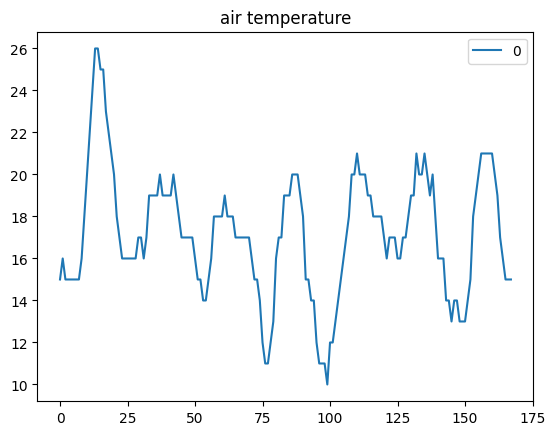

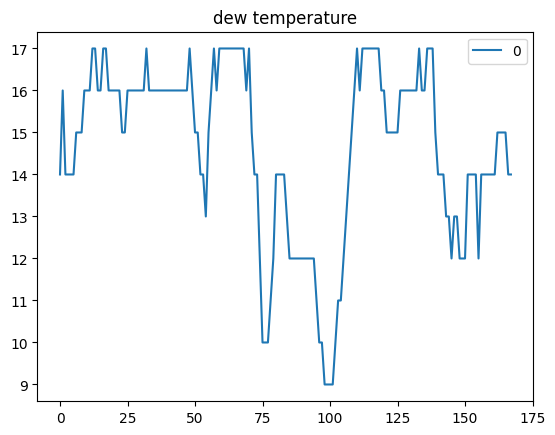

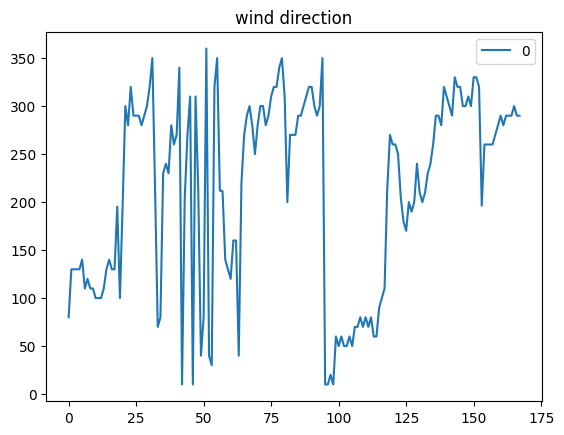

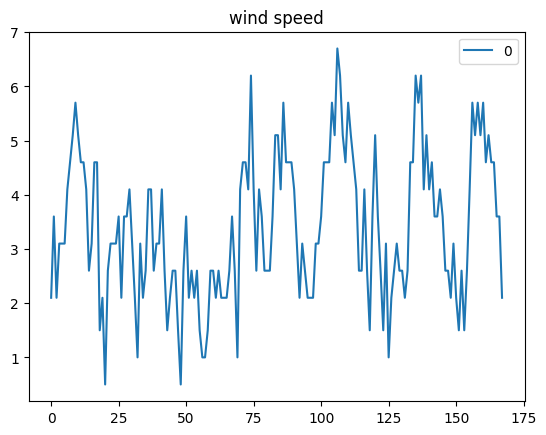

In [7]:
from matplotlib import pyplot as plt
pd.DataFrame(features[1, 0, :]).plot(title='air temperature')
pd.DataFrame(features[1, 1, :]).plot(title='dew temperature')
pd.DataFrame(features[1, 2, :]).plot(title='wind direction')
pd.DataFrame(features[1, 3, :]).plot(title='wind speed')
plt.show()

Next steps are quite straightforward. We need to fit the model and then predict the values for the test data just like for any other model in sklearn.

At the `fit` stage FedotIndustrial will transform initial time series data into features dataframe and will train regression model.

In [8]:
industrial_model =  evaluate_loop(api_params=params, finetune=True)

2024-04-04 15:55:08,487 - Initialising experiment setup
2024-04-04 15:55:08,503 - Initialising Industrial Repository
2024-04-04 15:55:08,632 - Initialising Dask Server
Creating Dask Server
2024-04-04 15:55:09,341 - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2024-04-04 15:55:09,375 - State start
2024-04-04 15:55:10,361 -   Scheduler at: inproc://10.64.4.217/16700/1
2024-04-04 15:55:10,361 -   dashboard at:  http://10.64.4.217:57469/status
2024-04-04 15:55:10,361 - Registering Worker plugin shuffle
2024-04-04 15:55:11,358 -       Start worker at: inproc://10.64.4.217/16700/4
2024-04-04 15:55:11,359 -          Listening to:          inproc10.64.4.217
2024-04-04 15:55:11,359 -           Worker name:                          0
2024-04-04 15:55:11,360 -          dashboard at:          10.64.4.217:57470
2024-04-04 15:55:11,360 - Waiting to connect to: inproc://10.64.4.217/16700/1
2024-04-04 15:55:11,361 - --------

[I 2024-04-04 16:07:41,649] A new study created in memory with name: no-name-680e6081-ecf6-4c24-ba92-32dfad27d4c6


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-04-04 16:11:33,392] Trial 1 finished with value: 469.3836309717183 and parameters: {'0 || treg | max_features': 0.05775924428054445, '0 || treg | min_samples_split': 20, '0 || treg | min_samples_leaf': 20, '0 || treg | bootstrap': True}. Best is trial 1 with value: 469.3836309717183.
[I 2024-04-04 16:11:33,725] Trial 0 finished with value: 461.5546704823826 and parameters: {'0 || treg | max_features': 0.9172096934223357, '0 || treg | min_samples_split': 6, '0 || treg | min_samples_leaf': 6, '0 || treg | bootstrap': True}. Best is trial 0 with value: 461.5546704823826.
[I 2024-04-04 16:11:34,116] Trial 2 finished with value: 466.0606524541281 and parameters: {'0 || treg | max_features': 0.9000416173564508, '0 || treg | min_samples_split': 17, '0 || treg | min_samples_leaf': 17, '0 || treg | bootstrap': True}. Best is trial 0 with value: 461.5546704823826.
[I 2024-04-04 16:11:34,457] Trial 4 finished with value: 464.40816428292965 and parameters: {'0 || treg | max_features': 0.36

At the end of the experiment we can obtain the desired metric values using `calculate_regression_metric` method. Now there are five available metrics for classification task:
- `explained_variance_score`
- `max_error`
- `mean_absolute_error`
- `mean_squared_error`
- `d2_absolute_error_score`.
- `median_absolute_error`
- `r2_score`

In [9]:
labels = industrial_model.predict(test_data)
metrics = industrial_model.get_metrics(target=test_data[1],
                                 rounding_order=3,
                                 metric_names=('r2', 'rmse', 'mae'))

In [10]:
metrics

,r2,rmse,mae
0,0.161,470.714,209.547


## AutoML approach

In [11]:
industrial_auto_model = evaluate_loop(api_params=params, finetune=False)

2024-04-04 16:47:57,482 - Initialising experiment setup
2024-04-04 16:47:57,499 - Initialising Industrial Repository
2024-04-04 16:47:57,500 - Initialising Dask Server
Creating Dask Server
2024-04-04 16:47:57,520 - State start
2024-04-04 16:47:58,505 -   Scheduler at: inproc://10.64.4.217/16700/9
2024-04-04 16:47:58,506 -   dashboard at:  http://10.64.4.217:58090/status
2024-04-04 16:47:58,507 - Registering Worker plugin shuffle
2024-04-04 16:47:59,504 -       Start worker at: inproc://10.64.4.217/16700/12
2024-04-04 16:47:59,505 -          Listening to:          inproc10.64.4.217
2024-04-04 16:47:59,506 -           Worker name:                          0
2024-04-04 16:47:59,506 -          dashboard at:          10.64.4.217:58093
2024-04-04 16:47:59,507 - Waiting to connect to: inproc://10.64.4.217/16700/9
2024-04-04 16:47:59,507 - -------------------------------------------------
2024-04-04 16:47:59,508 -               Threads:                          8
2024-04-04 16:47:59,508 -     

Generations:   0%|          | 0/10000 [00:00<?, ?gen/s]

2024-04-04 16:48:03,849 - IndustrialDispatcher - Number of used CPU's: 2


Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000025403806940>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2559918432144
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x000002541105EF70>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2560086593040
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000025406B56F70>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2560083699632
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy

2024-04-04 16:49:09,644 - IndustrialDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2024-04-04 16:49:09,687 - IndustrialEvoOptimizer - Generation num: 1 size: 1
2024-04-04 16:49:09,688 - IndustrialEvoOptimizer - Best individuals: HallOfFame archive fitness (1): ['<rmse=419.995 node_number=0.200>']
2024-04-04 16:49:10,868 - IndustrialDispatcher - Number of used CPU's: 2


Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000025410E1FC10>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2558680841360
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000025403563A60>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2560003265232
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x00000254059338B0>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2559884599344
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy

2024-04-04 16:57:42,094 - IndustrialDispatcher - 7 individuals out of 21 in previous population were evaluated successfully. 0.3333333333333333% is a fairly small percentage of successful evaluation.
2024-04-04 16:57:42,128 - IndustrialEvoOptimizer - Generation num: 2 size: 7
2024-04-04 16:57:42,130 - IndustrialEvoOptimizer - Best individuals: HallOfFame archive fitness (1): ['<rmse=417.786 node_number=0.300>']
2024-04-04 16:57:42,131 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 0/10000 [09:38<?, ?gen/s]

2024-04-04 16:57:42,134 - OptimisationTimer - Composition time: 9.638 min
2024-04-04 16:57:42,136 - OptimisationTimer - Algorithm was terminated due to processing time limit
2024-04-04 16:57:42,141 - IndustrialEvoOptimizer - Generation num: 3 size: 1
2024-04-04 16:57:42,143 - IndustrialEvoOptimizer - Best individuals: HallOfFame archive fitness (1): ['<rmse=417.786 node_number=0.300>']
2024-04-04 16:57:42,146 - IndustrialEvoOptimizer - no improvements for 1 iterations
2024-04-04 16:57:42,148 - IndustrialEvoOptimizer - spent time: 9.6 min
2024-04-04 16:57:42,153 - GPComposer - GP composition finished
2024-04-04 16:57:42,157 - DataSourceSplitter - Stratificated splitting of data is disabled.
2024-04-04 16:57:42,159 - DataSourceSplitter - Hold out validation is applied.
2024-04-04 16:57:42,169 - ApiComposer - Hyperparameters tuning started with 5 min. timeout
2024-04-04 16:57:42,172 - SimultaneousTuner - Hyperparameters optimization start: estimation of metric for initial graph


2024-04-04 16:57:53,096 - SimultaneousTuner - Initial graph: {'depth': 3, 'length': 3, 'nodes': [treg, scaling, quantile_extractor]}
treg - {}
scaling - {}
quantile_extractor - {} 
Initial metric: [477.156]
  0%|          | 0/100000 [00:00<?, ?trial/s, best loss=?]2024-04-04 16:57:53,129 - build_posterior_wrapper took 0.011000 seconds
2024-04-04 16:57:53,132 - TPE using 0 trials
  0%|          | 1/100000 [00:34<971:26:33, 34.97s/trial, best loss: 469.79105908050605]2024-04-04 16:58:28,103 - build_posterior_wrapper took 0.010981 seconds
2024-04-04 16:58:28,107 - TPE using 1/1 trials with best loss 469.791059
  0%|          | 2/100000 [01:10<983:54:07, 35.42s/trial, best loss: 465.9121764395481] 2024-04-04 16:59:03,839 - build_posterior_wrapper took 0.011975 seconds
2024-04-04 16:59:03,841 - TPE using 2/2 trials with best loss 465.912176
  0%|          | 3/100000 [01:27<741:57:41, 26.71s/trial, best loss: 460.8173609336631]2024-04-04 16:59:20,185 - build_posterior_wrapper took 0.011009 s

In [12]:
auto_labels = industrial_auto_model.predict(test_data)
auto_metrics = industrial_auto_model.get_metrics(target=test_data[1],
                                 rounding_order=3,
                                 metric_names=('r2', 'rmse', 'mae'))

In [13]:
auto_metrics

,r2,rmse,mae
0,0.087,491.02,212.539


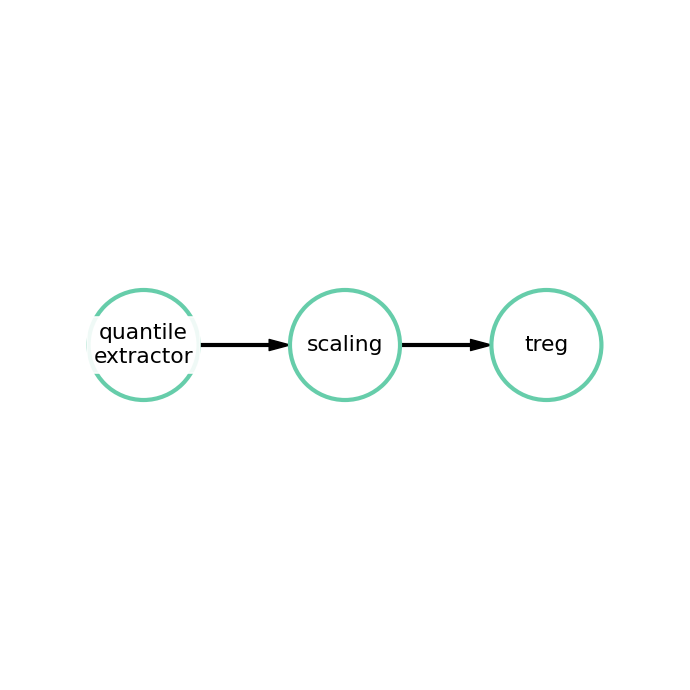

2024-04-04 17:08:10,349 - OperationsAnimatedBar - Visualizing optimization history... It may take some time, depending on the history size.
2024-04-04 17:08:10,450 - MovieWriter ffmpeg unavailable; using Pillow instead.
2024-04-04 17:08:10,451 - Animation.save using <class 'matplotlib.animation.PillowWriter'>
2024-04-04 17:08:15,804 - OperationsAnimatedBar - The animation was saved to "D:\WORK\Repo\Industiral\IndustrialTS\results_of_experiments\history_animated_bars.gif".
2024-04-04 17:08:15,806 - FitnessBox - Visualizing optimization history... It may take some time, depending on the history size.
2024-04-04 17:08:15,833 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-04-04 17:08:15,839 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the a

In [14]:
industrial_auto_model.solver.current_pipeline.show()
industrial_auto_model.plot_operation_distribution(mode='each')
industrial_auto_model.plot_fitness_by_generation()

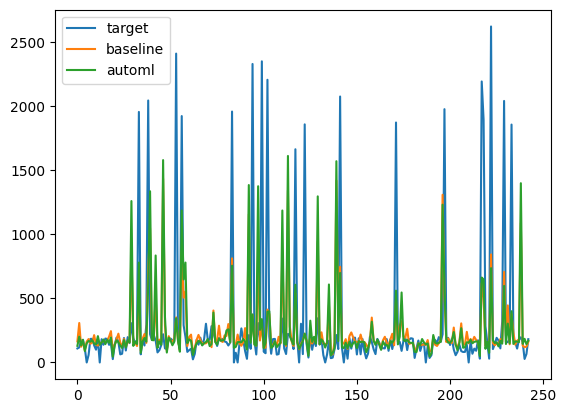

In [15]:
predictions = np.vstack([test_data[1].flatten(),labels.flatten(),auto_labels.flatten()]).T
all_prediction = pd.DataFrame(predictions,columns=['target','baseline','automl'])
all_prediction.plot()
plt.show()

## Compare with State of Art (SOTA) models

In [16]:
df = pd.read_csv(data_path+'/ts_regression_sota_results.csv',sep=';')
df = df[df['ds/type'] == dataset_name].iloc[:,:25]
df.index = df['algorithm']
df = df.drop(['algorithm','ds/type'], axis=1)
df = df.replace(',','.', regex=True).astype(float)

In [17]:
df['Fedot_Industrial_tuned'] = metrics['rmse'][0]
df['Fedot_Industrial_AutoML'] = auto_metrics['rmse'][0]
df = df.T

In [18]:
df.sort_values('min')['min']

CNN_RMSE                   387.616535
Grid-SVR_RMSE              390.641257
FPCR_RMSE                  399.459870
5NN-DTW_RMSE               407.790548
FPCR-Bs_RMSE               408.199670
5NN-ED_RMSE                424.504623
RandF_RMSE                 456.359415
Fedot_Industrial_tuned     470.714000
FreshPRINCE_RMSE           487.642605
ResNet_RMSE                489.719817
Fedot_Industrial_AutoML    491.020000
RDST_RMSE                  491.072419
ROCKET_RMSE                492.914183
DrCIF_RMSE                 494.923063
FCN_RMSE                   499.100408
SingleInception_RMSE       499.449452
InceptionT_RMSE            506.696071
MultiROCKET_RMSE           506.770267
Ridge_RMSE                 509.119169
TSF_RMSE                   510.156025
RotF_RMSE                  519.799244
XGBoost_RMSE               526.421564
1NN-ED_RMSE                529.096971
1NN-DTW_RMSE               557.562623
RIST_RMSE                  560.257921
Name: min, dtype: float64

In [19]:
df.sort_values('max')['max']

Fedot_Industrial_tuned     470.714000
Fedot_Industrial_AutoML    491.020000
FPCR_RMSE                  522.998212
FPCR-Bs_RMSE               537.381895
5NN-DTW_RMSE               546.981708
Grid-SVR_RMSE              553.666929
CNN_RMSE                   561.795243
5NN-ED_RMSE                562.413046
RDST_RMSE                  575.720140
RandF_RMSE                 589.478468
Ridge_RMSE                 627.513473
ROCKET_RMSE                629.215008
RIST_RMSE                  639.787936
FreshPRINCE_RMSE           640.463800
InceptionT_RMSE            645.057362
DrCIF_RMSE                 646.879703
SingleInception_RMSE       652.585529
ResNet_RMSE                661.954851
TSF_RMSE                   663.258974
MultiROCKET_RMSE           663.968054
RotF_RMSE                  670.442108
FCN_RMSE                   693.068654
XGBoost_RMSE               693.574841
1NN-DTW_RMSE               755.854409
1NN-ED_RMSE                812.146002
Name: max, dtype: float64

In [1]:
df.sort_values('average')['average']

NameError: name 'df' is not defined